In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import scipy.stats as stats
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.interface.iem_fung92_brogioni10 import IEM_Fung92_Briogoni10
from smrt import SMRTError
from IPython.display import clear_output

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions import forward_mean, forward_OIB
from prepare_inputs_OE import prepare_inputs, prepare_inputs_FYI
import prepare_inputs_OE as piO

In [2]:
def corrMat(self, data):
    ## Make correlation matrix - input covariance matrix
    corrMat = np.zeros(data.shape)
    sigmas = np.diag(data)**(1/2)
    rows = range(data.shape[0])
    cols = range(data.shape[1])
    for row in rows:
        sigma1 = sigmas[row]
        for col in cols:
            sigma2 = sigmas[col]

            corrMat[row][col] = np.array(data)[row][col]/(sigma1*sigma2)

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(corrMat, cmap="inferno")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(data.keys())), labels=data.keys())
    ax.set_yticks(np.arange(len(data.keys())), labels=data.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    for i in range(len(data.keys())):
        for j in range(len(data.keys())):
            if np.round(corrMat[i, j],2) > 0.5:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                               ha="center", va="center", color="w")

    ax.set_title(r'Output correlation matrix')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


    fig.tight_layout()
    plt.savefig(savepath + str(V_sens) + '_CorrOut.png' )
    plt.show()
    
def covMat(self, data, title):
    for var in self.x_vars:
        print(var)
        data[var][var] = data[var][var]**(1/2)
    ## get std
    try:
       data['lex']['lex'] = data['lex']['lex']*1e1
    except:
        pass
    try:
        data['sal']['sal'] = data['sal']['sal']*1e1
    except:
        pass
    try:
        data['Tsur']['Tsur'] = data['Tsur']['Tsur']/1e2
    except:
        pass
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(
        data*1e2,
        annot=True, 
        fmt='.4f', 
        ax=ax, 
        linewidths=.05, 
        cbar_kws={'label':'Modified Covariance [log10(cm),log10(mm),log10(PSU),cm]'}
    )
    ax.set_title(title)
    if 'out' in title:
        plt.savefig(savepath + str(V_sens) + '_CovOut.png' )
    else:
        plt.savefig(savepath + str(V_sens) +'_CovIn.png' )
    plt.show()
def makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB):
    nl_snow = 2
    x_vars = list(x_upperLimit.keys())
    forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow, "n": 0, "pol":polarization
                     , "nls":1, "avg":True, "sim":True}
    oe = pyOE.optimalEstimation(
    x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
    ,forwardKwArgs=forwardKwArgs
    ,x_lowerLimit=x_lowerLimit
    ,x_upperLimit=x_upperLimit
    )
    return oe
def calc_ang(var1, var2):
    
    text_file = open(savepath + "angles_jacobian.txt", "a")
    
    J = oe.getJacobian(oe.x_op, oe.y_op)[0]
    print('--------------------------------------------------')
    text_file.write('--------------------------------------------------\n')
    
    denominator = np.linalg.norm(J['perturbed '+var1][:5])*np.linalg.norm(J['perturbed '+var2][:5])
    nominator = np.dot(J['perturbed '+var1][:5], J['perturbed '+var2][:5])
    print('Angle between '+var1+' and '+var2+' vector V:', np.rad2deg(np.arccos(nominator/denominator)))
    text_file.write('Angle between '+var1+' and '+var2+' vector V:' + str(np.rad2deg(np.arccos(nominator/denominator))) + '\n')

    
    denominator = np.linalg.norm(J['perturbed '+var1][5:])*np.linalg.norm(J['perturbed '+var2][5:])
    nominator = np.dot(J['perturbed '+var1][5:], J['perturbed '+var2][5:])
    print('Angle between '+var1+' and '+var2+ ' vector H:', np.rad2deg(np.arccos(nominator/denominator)))
    text_file.write('Angle between '+var1+' and '+var2+' vector H:' + str(np.rad2deg(np.arccos(nominator/denominator))) + '\n')
def covOutMat(oe1, oe2):
    data=oe1/oe2
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(
        data,
        annot=True, 
        fmt='.4f', 
        ax=ax, 
        linewidths=.05, 
        cbar_kws={'label':'Ratio of covariance compared to input'}
    )
    ax.set_title('comparison')
    plt.savefig(savepath + str(V_sens) + '_CovRatioOuttoIn.png' )
    plt.show()

In [3]:
FYI_data = piO.OIB_data('FYI')

FYI_OIB_SIM = np.concatenate([np.mean(FYI_data.TbV_sim, axis=0), np.mean(FYI_data.TbH_sim, axis=0)])
FYI_OIB_AMSR = np.concatenate([np.mean(FYI_data.TbV_AMSR_all, axis=0), np.mean(FYI_data.TbH_AMSR_all, axis=0)])

FYI_OIB_AMSR_std = np.concatenate([np.std(FYI_data.TbV_AMSR_all, axis=0), np.std(FYI_data.TbH_AMSR_all, axis=0)])

## Make simulated data with noise
FYI_OIB_SIM_gaussian = FYI_OIB_SIM

### Choose looking at only V or at both

### Choose how many input variables 

### choose Sy sensitivity

In [4]:
# Saving location
savepath = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Logarithmic_tests/' + '/Only V/Sy_test/SD_sit/SY_tests/'

# Polarization (V or both)
polarization = 'V'
# sensitivity of TBs (std)
V_sens = 2.0 # K
H_sens = 2.0 # K
# List with input variables
input_variables = ["SD" , "lex", "sal", "SIT"]
## list with true values
x_truth = [np.log10(np.mean(FYI_data.sd, axis=0)[0]),
           #np.log10(np.mean(FYI_data.sd_lex, axis=0)[0]),
           #np.log10(np.mean(FYI_data.sd_sal, axis=0)[0])] #,
           np.mean(FYI_data.sit)]

In [5]:
## Define name of y-variables
if polarization=='both':
    y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"]
    y_obs  = FYI_OIB_SIM_gaussian
    y_cov = np.diag([V_sens**2]*5 + [H_sens**2]*5)
elif polarization=='V':
    y_vars = ["6V", "10V", "18V", "23V", "36V"]
    y_obs = np.mean(FYI_data.TbV_sim, axis=0)
    y_cov = np.diag([V_sens**2]*5)

# Define name of x-variable
x_vars = input_variables
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(FYI_data, x_vars, logarithmic=True, sim=True, nls=1)

print(x_ap)
print('Guess in linear units', 10**np.round(x_ap,2)[:3])

Logarithmic convertion made
[-3.66781226]
Convertin SD variances to log10
Convertin lex variances to log10
Convertin sal variances to log10
[-0.91838903 -3.66781226 -3.0515771   1.43982817]
Guess in linear units [0.12022644 0.0002138  0.00089125]


Text(0.5, 1.0, 'Measurement uncertainty (STD) $\\mathbf{S}_{y}$')

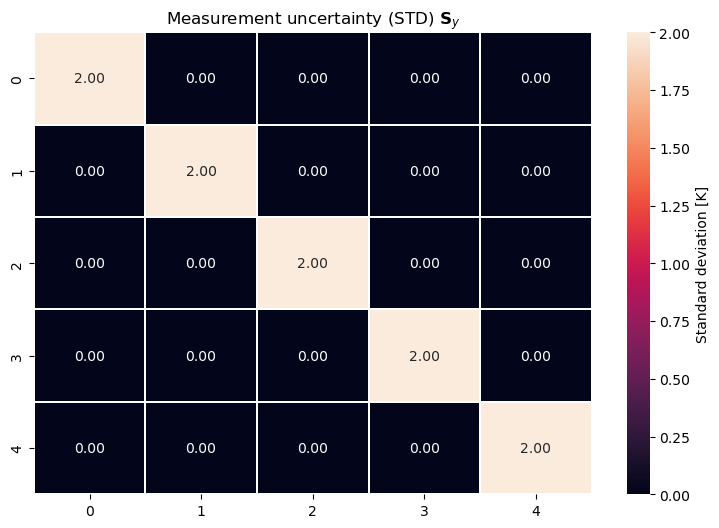

In [6]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    np.sqrt(y_cov), 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Standard deviation [K]'}
)
ax.set_title(r'Measurement uncertainty (STD) $\mathbf{S}_{y}$')

Logarithmic convertion made
[-3.66781226]
Convertin SD variances to log10
Convertin lex variances to log10
Convertin sal variances to log10
[[ 0.02050176  0.00270736 -0.01705278  0.01736241]
 [ 0.00270736  0.00059791 -0.0018802   0.00217434]
 [-0.01705278 -0.0018802   0.01818367 -0.01244202]
 [ 0.01736241  0.00217434 -0.01244202  0.09241524]]
SD
lex
sal
SIT


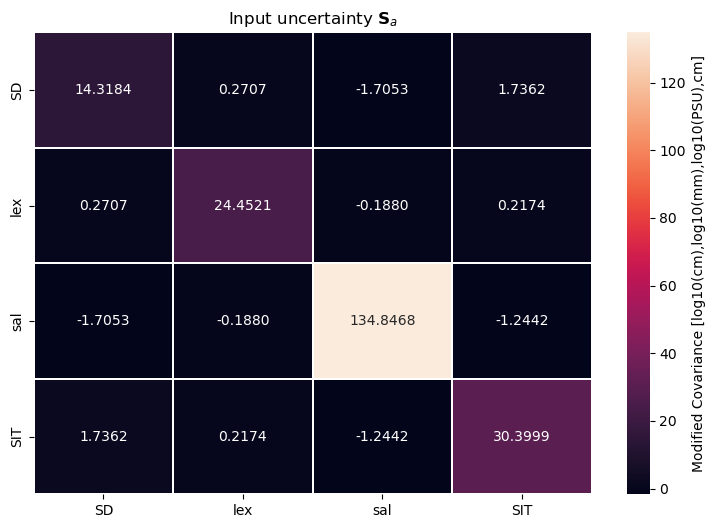

In [7]:
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(FYI_data,x_vars, logarithmic=True, sim=True, nls=1)
print(x_cov)
try:
    float(x_cov)
    x_cov= np.array([[x_cov]])
except:
    pass
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB)
title = r'Input uncertainty $\mathbf{S}_{a}$'
covMat(oe_show, oe_show.S_a, title)

['SD', 'SIT']
[-0.91838903  1.43982817]
[[0.14318437 0.        ]
 [0.         0.09241524]]
0.70 s, iteration 1, degrees of freedom: 0.93 of 2, converged (x-space):  0.000
0.98 s, iteration 2, degrees of freedom: 0.93 of 2, done.  0.000
-----------------
TRUE VALUES
-----------------
SD:  [0.12067324 0.03      ]
lex:  [0.21487592 0.25216876]
sal:  [0.88802032 8.67319838]
SIT:  1.4398281690140846
-----------------
SD    -0.940190
SIT    1.448949
dtype: float64
SD    11.476527
dtype: float64
SIT    28115.694952
dtype: float64
-----------------
Jacobian matrix:
      perturbed SD  perturbed SIT
6V       7.697190      -2.735843
10V      7.875514      -2.728857
18V      7.413634      -2.723024
23V      6.645534      -2.658075
36V      5.378484      -3.119416


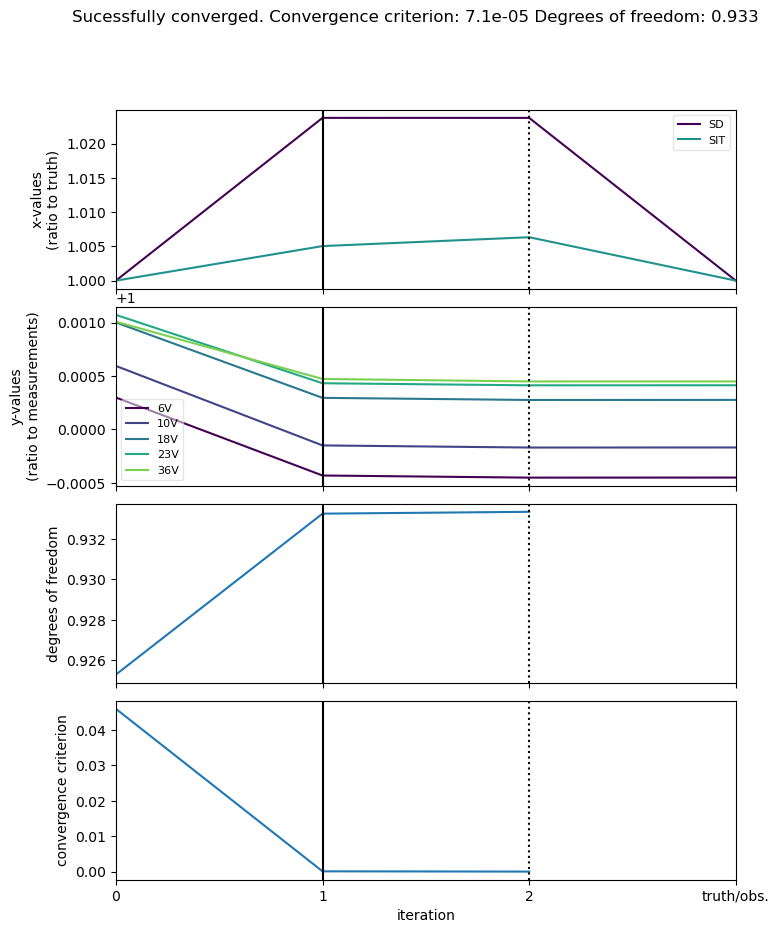

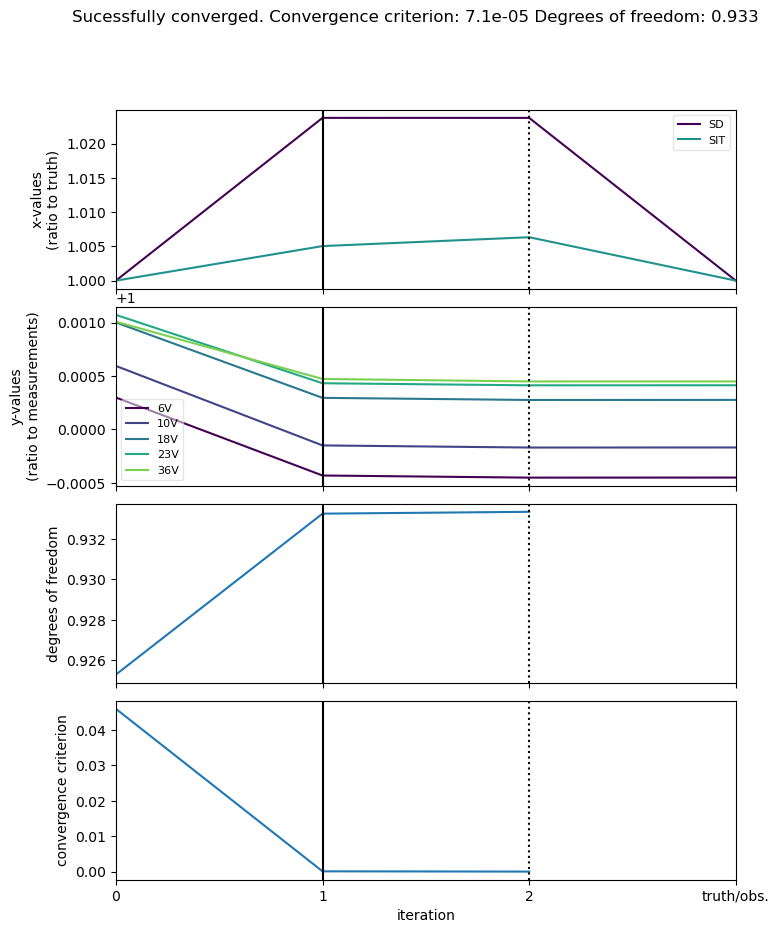

In [8]:
## Iterate over different start guesses

## scale covariance ? and convert to diagonal
try:
    d = np.diag(x_cov)
    x_cov = np.diag(d)
except:
    print('One dimensional marix')
    x_cov = np.array([[x_cov]])
    

## define extra arguments to forward function
nl_snow=2
x_vars = list(x_upperLimit.keys())
print(x_vars)
print(x_ap)
print(x_cov)
forwardKwArgs = {"self":FYI_data,"variables": x_vars, "nl_snow": nl_snow, "n": 0, "pol":polarization,
                 "logarithmic": True, "nls":1, "avg":True, "sim":True}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,x_truth=x_truth
        ,convergenceFactor=10
        )
# run the optimization and print outputs
oe.doRetrieval(maxIter=8)
print('-----------------')
print('TRUE VALUES')
print('-----------------')
print('SD: ', np.mean(FYI_data.sd, axis=0))
print('lex: ',np.mean(FYI_data.sd_lex, axis=0)*1e3)
print('sal: ',np.mean(FYI_data.sd_sal, axis=0)*1e3)
print('SIT: ',np.mean(FYI_data.sit))

print('-----------------')
print(oe.x_op)
print(10**(oe.x_op[:1])*1e2)
try:
    print(10**(oe.x_op[1:3])*1e3)
except:
    pass
# print((oe.x_op[3:]))
print('-----------------')
print('Jacobian matrix:\n', oe.getJacobian(oe.x_op, oe.y_op)[0])
oe.plotIterations()

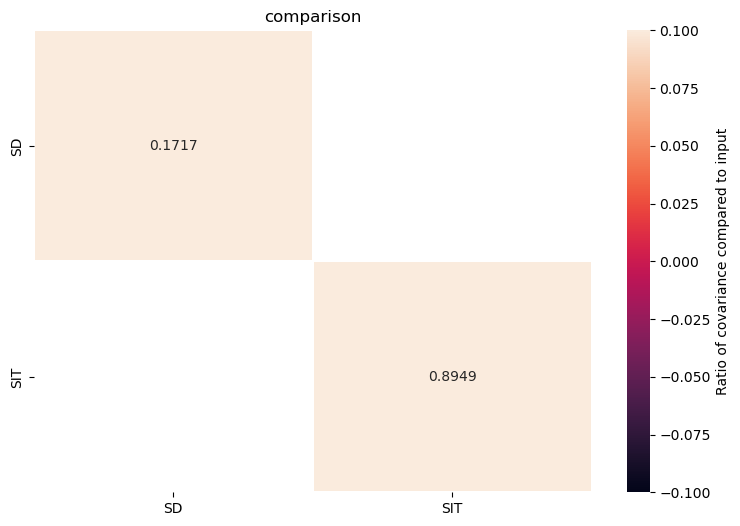

In [9]:
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB)
covOutMat(oe.S_op, oe_show.S_a)

In [10]:
## calculate angles if we have more than 1 input variable
text_file = open(savepath + "angles_jacobian.txt", "w")
if len(input_variables)>1:
    for i in range(len(input_variables)):
        for j in range(len(input_variables)):
            if i!=j:
                calc_ang(input_variables[i], input_variables[j])

--------------------------------------------------
Angle between SD and SIT vector V: 169.64372984367938
Angle between SD and SIT vector H: nan
--------------------------------------------------
Angle between SIT and SD vector V: 169.64372984367938
Angle between SIT and SD vector H: nan


### Test for assumptions

In [11]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)
chiSquareTest = oe.chiSquareTest(significance=0.05)
print('\nTests passed:\n' ,chiSquareTest[0])

Linearity test passed:  True
Warning. Singular Matrix with rank 2 instead of 5. (This is typically save to ignore)       

Tests passed:
 chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


Logarithmic convertion made
Convertin SD variances to log10
0.58 s, iteration 1, degrees of freedom: 0.70 of 2, converged (x-space):  0.004
0.86 s, iteration 2, degrees of freedom: 0.70 of 2, done.  0.000
0.62 s, iteration 1, degrees of freedom: 0.70 of 2, converged (x-space):  0.001
0.90 s, iteration 2, degrees of freedom: 0.70 of 2, done.  0.000
0.59 s, iteration 1, degrees of freedom: 0.70 of 2, converged (x-space):  0.001
0.88 s, iteration 2, degrees of freedom: 0.70 of 2, done.  0.000
0.71 s, iteration 1, degrees of freedom: 0.70 of 2, converged (x-space):  0.000
1.02 s, iteration 2, degrees of freedom: 0.70 of 2, done.  0.000
0.70 s, iteration 1, degrees of freedom: 0.70 of 2, converged (x-space):  0.000
1.01 s, iteration 2, degrees of freedom: 0.70 of 2, done.  0.000
0.76 s, iteration 1, degrees of freedom: 0.70 of 2, converged (x-space):  0.000
1.08 s, iteration 2, degrees of freedom: 0.70 of 2, done.  0.000
0.72 s, iteration 1, degrees of freedom: 0.71 of 2, converged (x-space

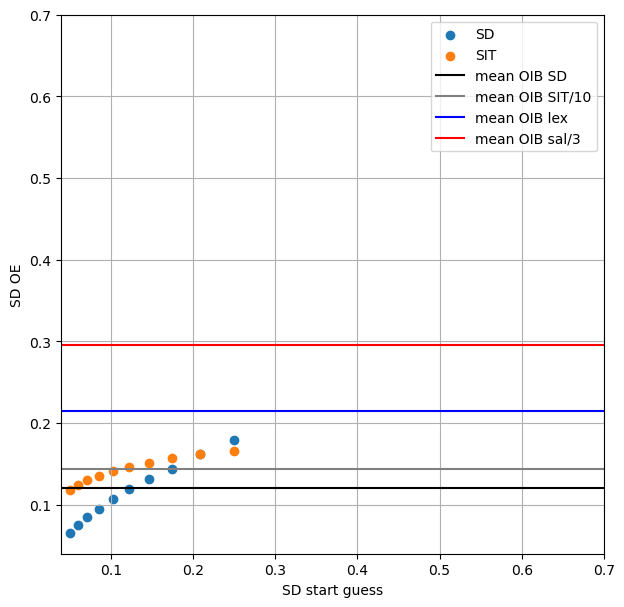

Logarithmic convertion made
Convertin SD variances to log10
0.73 s, iteration 1, degrees of freedom: 0.76 of 2, not converged (x-space):  0.363
1.02 s, iteration 2, degrees of freedom: 0.77 of 2, converged (x-space):  0.010
1.34 s, iteration 3, degrees of freedom: 0.77 of 2, done.  0.001
0.67 s, iteration 1, degrees of freedom: 0.75 of 2, converged (x-space):  0.138
0.95 s, iteration 2, degrees of freedom: 0.76 of 2, done.  0.003
0.68 s, iteration 1, degrees of freedom: 0.94 of 2, converged (x-space):  0.024
0.98 s, iteration 2, degrees of freedom: 0.79 of 2, done.  0.092
0.68 s, iteration 1, degrees of freedom: 0.79 of 2, converged (x-space):  0.058
0.97 s, iteration 2, degrees of freedom: 0.75 of 2, done.  0.007
0.72 s, iteration 1, degrees of freedom: 0.73 of 2, converged (x-space):  0.004
1.04 s, iteration 2, degrees of freedom: 0.73 of 2, done.  0.000
0.67 s, iteration 1, degrees of freedom: 0.71 of 2, converged (x-space):  0.000
0.95 s, iteration 2, degrees of freedom: 0.71 of 2,

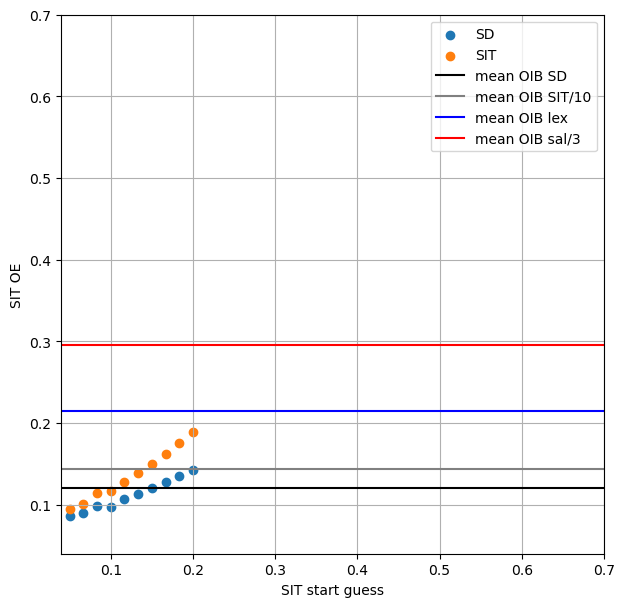

In [12]:
## Iterate over different start guesses (of SD)
for var in input_variables:
    [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(FYI_data,input_variables,logarithmic=True, sim=True, nls=1)
    
    #x_cov[0,0]=x_cov[0,0]*5
    #x_cov[1,1]=x_cov[1,1]
    #x_cov[3,3]=x_cov[3,3]/2
    #x_cov[1,1]=x_cov[1,1]*2
    try:
        d = np.diag(x_cov)
        x_cov = np.diag(d)
    except:
        print('One dimensional marix')
        x_cov = np.array([[x_cov]])
    
    cc = []
    x_op = []
    ind = [i==var for i in input_variables]
    if var=='SD':
        V0 = np.linspace(np.log10(0.05), np.log10(0.25), 10)
    elif var=='lex':
        V0 =  np.linspace(np.log10(0.05*1e-3), np.log10(0.4*1e-3), 10)
    elif var=='sal':
        V0 =  np.linspace(np.log10(0.1*PSU), np.log10(2*PSU), 10)
    elif var=='SIT':
        V0 = np.linspace(0.5, 2.0, 10)

    for v0 in V0:
        x_ap[ind] =v0
        ## define extra arguments to forward function
        nl_snow=2
        x_vars = list(x_upperLimit.keys())
        forwardKwArgs = {"self":FYI_data,"variables": x_vars, "nl_snow": nl_snow, "n": 0, "pol":polarization,
                         "logarithmic": True, "nls":1, "avg":True, "sim":True}
        # define the optimal estimation
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,convergenceFactor=10
                )

        try:
            # run the optimization and print outputs
            oe.doRetrieval(maxIter=6)
            oe.plotIterations
            # SD_out.append(oe.x_op['SD'])
            cc.append(oe.S_op)
            x_op.append(oe.x_op)
        except:
            print('NC')
            V0 = np.delete(V0, [np.where(V0==v0)])
        
    ## Plot results
    plt.figure(figsize=(7,7))
    print(var)
    for i in range(len(input_variables)):
        print(i)
        
        if input_variables[i]!="SIT":
            V = [10**x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        else:
            V = [x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        if var!="SIT":
            VV0 = [10**v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        else:
            VV0 = [v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        if input_variables[i]=="lex" or input_variables[i]=="sal":
            V = np.array(V)*1e3
        if var=="lex" or var=="sal":
            VV0 = np.array(VV0)*1e3
        if var=="sal":
            VV0 = VV0/3
        if input_variables[i]=="sal":
            V=V/3
            
        if var=="SIT":
            VV0 = np.array(VV0)/10
        if input_variables[i]=="SIT":
            V=np.array(V)/10
        plt.scatter(VV0, V, label=input_variables[i])

    plt.xlabel(var + ' start guess')
    plt.ylabel(var +' OE')
    plt.axhline(np.mean(FYI_data.sd, axis=0)[0], color='k', label='mean OIB SD')
    plt.axhline(np.mean(FYI_data.sit)/10, color='grey', label='mean OIB SIT/10')
    plt.axhline(np.mean(FYI_data.sd_lex, axis=0)[0]*1e3, color='b', label='mean OIB lex')
    plt.axhline(np.mean(FYI_data.sd_sal, axis=0)[0]*1e3/3, color='r', label='mean OIB sal/3')
    plt.xlim([0.04, 0.7])
    plt.ylim([0.04, 0.7])
    #plt.xlim([np.min(VV0)-np.min(VV0)/10,np.max(VV0)+np.max(VV0)/10])
    #plt.ylim([np.min(VV0)-np.min(VV0)/10,np.max(VV0)+np.max(VV0)/10])
    plt.legend()
    plt.grid()
    plt.savefig(savepath + var + '_' + str(V_sens) + '.png' )
    plt.show()

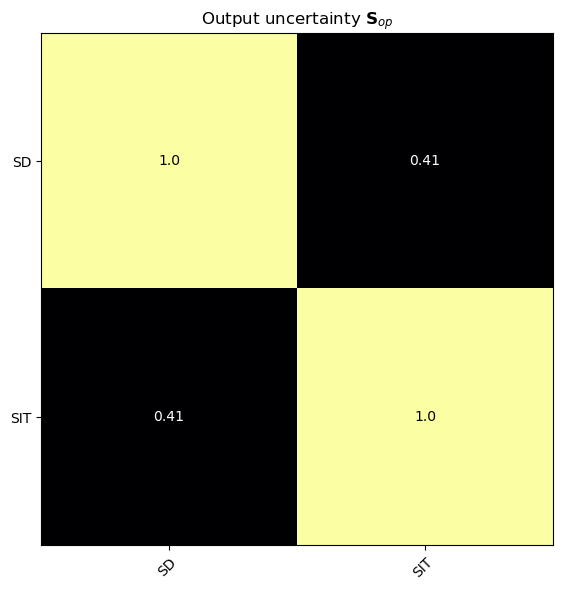

In [13]:
#def corrMat(data):
corrMat = np.zeros(oe.S_op.shape)
sigmas = np.diag(oe.S_op)**(1/2)
rows = range(oe.S_op.shape[0])
cols = range(oe.S_op.shape[1])
for row in rows:
    sigma1 = sigmas[row]
    for col in cols:
        sigma2 = sigmas[col]
        
        corrMat[row][col] = np.array(oe.S_op)[row][col]/(sigma1*sigma2)

        
        
 
fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(corrMat, cmap="inferno")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())
ax.set_yticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations.
for i in range(len(oe.S_op.keys())):
    for j in range(len(oe.S_op.keys())):
        if np.round(corrMat[i, j],2) > 0.5:
            text = ax.text(j, i, np.round(corrMat[i, j],2),
                   ha="center", va="center", color="k")
        else:
            text = ax.text(j, i, np.round(corrMat[i, j],2),
                           ha="center", va="center", color="w")

ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


fig.tight_layout()
plt.savefig(savepath + str(V_sens) + '_CorrMatrixOut.png' )
plt.show()

In [14]:
ns = len(FYI_data.skt)
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(FYI_data,input_variables, logarithmic=True, sim=True, nls=1)

try:
    x_cov[0,0]=x_cov[0,0]*2
    # x_cov[3,3]=x_cov[3,3]/2
    d = np.diag(x_cov)
    x_cov = np.diag(d)
except:
    print('One dimensional marix')
    x_cov = np.array([[x_cov]])

def do_OE_sim(ns, noise=False):
    if polarization=='both':
        data=zip(FYI_data.TbV_sim[:ns], FYI_data.TbH_sim[:ns])
    elif polarization=='V':
        data=FYI_data.TbV_sim[:ns]
    results = []
    x_optimals = []
    nn = [i for i in range(ns)]
    no = []
    for Tb, n in zip(data, range(len(FYI_data.skt[:ns]))):
        print('Point number: ', n)
        forwardKwArgs = {"self":FYI_data, "variables": x_vars, "nl_snow": 2, "n": n, "pol":polarization
                         , "logarithmic": True, "nls":1, "avg":False, "sim":True}
        # define the optimal estimation
        y_obs = np.array(Tb).flatten()
        # print(y_obs)
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,convergenceFactor=10
                )
        try:
            oe.doRetrieval(maxIter=5)
            x_optimals.append(oe.x_op)
            results.append(oe.y_op)
        except:
            print('Convergence not reached')
            nn.remove(n)
            no.append(n)
    return [nn, no, x_optimals, results]

[nn, no, x_optimals, results] = do_OE_sim(ns)

Logarithmic convertion made
Convertin SD variances to log10
Point number:  0
0.74 s, iteration 1, degrees of freedom: 0.84 of 2, converged (x-space):  0.002
1.06 s, iteration 2, degrees of freedom: 0.84 of 2, done.  0.000
Point number:  1
0.74 s, iteration 1, degrees of freedom: 0.85 of 2, converged (x-space):  0.001
1.06 s, iteration 2, degrees of freedom: 0.85 of 2, done.  0.000
Point number:  2
0.70 s, iteration 1, degrees of freedom: 0.85 of 2, converged (x-space):  0.008
1.00 s, iteration 2, degrees of freedom: 0.85 of 2, done.  0.000
Point number:  3
0.69 s, iteration 1, degrees of freedom: 0.85 of 2, converged (x-space):  0.003
0.99 s, iteration 2, degrees of freedom: 0.85 of 2, done.  0.000
Point number:  4
0.71 s, iteration 1, degrees of freedom: 0.90 of 2, converged (x-space):  0.000
1.02 s, iteration 2, degrees of freedom: 0.90 of 2, done.  0.000
Point number:  5
0.70 s, iteration 1, degrees of freedom: 0.91 of 2, converged (x-space):  0.000
1.01 s, iteration 2, degrees of f

0.74 s, iteration 1, degrees of freedom: 0.82 of 2, converged (x-space):  0.000
1.06 s, iteration 2, degrees of freedom: 0.82 of 2, done.  0.000
Point number:  51
0.76 s, iteration 1, degrees of freedom: 0.83 of 2, converged (x-space):  0.002
1.10 s, iteration 2, degrees of freedom: 0.83 of 2, done.  0.000
Point number:  52
0.78 s, iteration 1, degrees of freedom: 0.81 of 2, converged (x-space):  0.007
1.11 s, iteration 2, degrees of freedom: 0.80 of 2, done.  0.000
Point number:  53
0.72 s, iteration 1, degrees of freedom: 0.80 of 2, converged (x-space):  0.007
1.04 s, iteration 2, degrees of freedom: 0.80 of 2, done.  0.000
Point number:  54
0.75 s, iteration 1, degrees of freedom: 0.81 of 2, converged (x-space):  0.007
1.08 s, iteration 2, degrees of freedom: 0.81 of 2, done.  0.000
Point number:  55
0.77 s, iteration 1, degrees of freedom: 0.80 of 2, converged (x-space):  0.013
1.11 s, iteration 2, degrees of freedom: 0.79 of 2, done.  0.000
Point number:  56
0.78 s, iteration 1, d

1.05 s, iteration 2, degrees of freedom: 0.87 of 2, done.  0.000
Point number:  101
0.72 s, iteration 1, degrees of freedom: 0.86 of 2, converged (x-space):  0.000
0.97 s, iteration 2, degrees of freedom: 0.86 of 2, done.  0.000
Point number:  102
0.72 s, iteration 1, degrees of freedom: 0.81 of 2, converged (x-space):  0.000
1.00 s, iteration 2, degrees of freedom: 0.81 of 2, done.  0.000
Point number:  103
0.74 s, iteration 1, degrees of freedom: 0.79 of 2, converged (x-space):  0.000
1.05 s, iteration 2, degrees of freedom: 0.79 of 2, done.  0.000
Point number:  104
0.72 s, iteration 1, degrees of freedom: 0.81 of 2, converged (x-space):  0.000
1.05 s, iteration 2, degrees of freedom: 0.82 of 2, done.  0.000
Point number:  105
0.69 s, iteration 1, degrees of freedom: 0.78 of 2, converged (x-space):  0.002
1.02 s, iteration 2, degrees of freedom: 0.78 of 2, done.  0.000
Point number:  106
0.71 s, iteration 1, degrees of freedom: 0.75 of 2, converged (x-space):  0.003
1.01 s, iteratio

0.79 s, iteration 1, degrees of freedom: 0.77 of 2, converged (x-space):  0.000
1.13 s, iteration 2, degrees of freedom: 0.77 of 2, done.  0.000
Point number:  151
0.77 s, iteration 1, degrees of freedom: 0.84 of 2, converged (x-space):  0.000
1.11 s, iteration 2, degrees of freedom: 0.84 of 2, done.  0.000
Point number:  152
0.79 s, iteration 1, degrees of freedom: 0.85 of 2, converged (x-space):  0.000
1.12 s, iteration 2, degrees of freedom: 0.85 of 2, done.  0.000
Point number:  153
0.77 s, iteration 1, degrees of freedom: 0.84 of 2, converged (x-space):  0.001
1.10 s, iteration 2, degrees of freedom: 0.84 of 2, done.  0.000
Point number:  154
0.78 s, iteration 1, degrees of freedom: 0.83 of 2, converged (x-space):  0.001
1.11 s, iteration 2, degrees of freedom: 0.83 of 2, done.  0.000
Point number:  155
0.78 s, iteration 1, degrees of freedom: 0.79 of 2, converged (x-space):  0.002
1.10 s, iteration 2, degrees of freedom: 0.79 of 2, done.  0.000
Point number:  156
0.73 s, iteratio

0.78 s, iteration 1, degrees of freedom: 0.76 of 2, converged (x-space):  0.000
1.09 s, iteration 2, degrees of freedom: 0.76 of 2, done.  0.000
Point number:  201
0.73 s, iteration 1, degrees of freedom: 0.75 of 2, converged (x-space):  0.002
1.05 s, iteration 2, degrees of freedom: 0.75 of 2, done.  0.000
Point number:  202
0.74 s, iteration 1, degrees of freedom: 0.77 of 2, converged (x-space):  0.002
1.10 s, iteration 2, degrees of freedom: 0.77 of 2, done.  0.000
Point number:  203
0.69 s, iteration 1, degrees of freedom: 0.73 of 2, converged (x-space):  0.003
1.01 s, iteration 2, degrees of freedom: 0.73 of 2, done.  0.000
Point number:  204
0.80 s, iteration 1, degrees of freedom: 0.74 of 2, converged (x-space):  0.003
1.12 s, iteration 2, degrees of freedom: 0.74 of 2, done.  0.000
Point number:  205
0.71 s, iteration 1, degrees of freedom: 0.74 of 2, converged (x-space):  0.003
1.03 s, iteration 2, degrees of freedom: 0.75 of 2, done.  0.000
Point number:  206
0.73 s, iteratio

0.81 s, iteration 1, degrees of freedom: 0.82 of 2, converged (x-space):  0.000
1.11 s, iteration 2, degrees of freedom: 0.82 of 2, done.  0.000
Point number:  251
0.72 s, iteration 1, degrees of freedom: 0.87 of 2, converged (x-space):  0.000
1.02 s, iteration 2, degrees of freedom: 0.87 of 2, done.  0.000
Point number:  252
0.82 s, iteration 1, degrees of freedom: 0.86 of 2, converged (x-space):  0.000
1.18 s, iteration 2, degrees of freedom: 0.86 of 2, done.  0.000
Point number:  253
0.77 s, iteration 1, degrees of freedom: 0.85 of 2, converged (x-space):  0.000
1.12 s, iteration 2, degrees of freedom: 0.85 of 2, done.  0.000
Point number:  254
0.78 s, iteration 1, degrees of freedom: 0.85 of 2, converged (x-space):  0.000
1.11 s, iteration 2, degrees of freedom: 0.85 of 2, done.  0.000
Point number:  255
0.77 s, iteration 1, degrees of freedom: 0.84 of 2, converged (x-space):  0.000
1.12 s, iteration 2, degrees of freedom: 0.84 of 2, done.  0.000
Point number:  256
0.80 s, iteratio

0.76 s, iteration 1, degrees of freedom: 0.83 of 2, converged (x-space):  0.000
1.04 s, iteration 2, degrees of freedom: 0.83 of 2, done.  0.000
Point number:  301
0.77 s, iteration 1, degrees of freedom: 0.83 of 2, converged (x-space):  0.000
1.12 s, iteration 2, degrees of freedom: 0.83 of 2, done.  0.000
Point number:  302
0.79 s, iteration 1, degrees of freedom: 0.83 of 2, converged (x-space):  0.000
1.08 s, iteration 2, degrees of freedom: 0.83 of 2, done.  0.000
Point number:  303
0.75 s, iteration 1, degrees of freedom: 0.83 of 2, converged (x-space):  0.001
1.06 s, iteration 2, degrees of freedom: 0.83 of 2, done.  0.000
Point number:  304
0.73 s, iteration 1, degrees of freedom: 0.83 of 2, converged (x-space):  0.002
1.06 s, iteration 2, degrees of freedom: 0.83 of 2, done.  0.000
Point number:  305
0.78 s, iteration 1, degrees of freedom: 0.82 of 2, converged (x-space):  0.000
1.11 s, iteration 2, degrees of freedom: 0.82 of 2, done.  0.000
Point number:  306
0.74 s, iteratio

0.78 s, iteration 1, degrees of freedom: 0.57 of 2, converged (x-space):  0.000
1.10 s, iteration 2, degrees of freedom: 0.57 of 2, done.  0.000
Point number:  351
0.75 s, iteration 1, degrees of freedom: 0.71 of 2, converged (x-space):  0.000
1.10 s, iteration 2, degrees of freedom: 0.71 of 2, done.  0.000
Point number:  352
0.83 s, iteration 1, degrees of freedom: 0.72 of 2, converged (x-space):  0.000
1.14 s, iteration 2, degrees of freedom: 0.72 of 2, done.  0.000
Point number:  353
0.76 s, iteration 1, degrees of freedom: 0.74 of 2, converged (x-space):  0.000
1.08 s, iteration 2, degrees of freedom: 0.74 of 2, done.  0.000
Point number:  354
0.74 s, iteration 1, degrees of freedom: 0.76 of 2, converged (x-space):  0.000
1.06 s, iteration 2, degrees of freedom: 0.76 of 2, done.  0.000


In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

def RMSE(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
    
    print("Root Mean Square Error:")
    print(RMSE)
    return RMSE

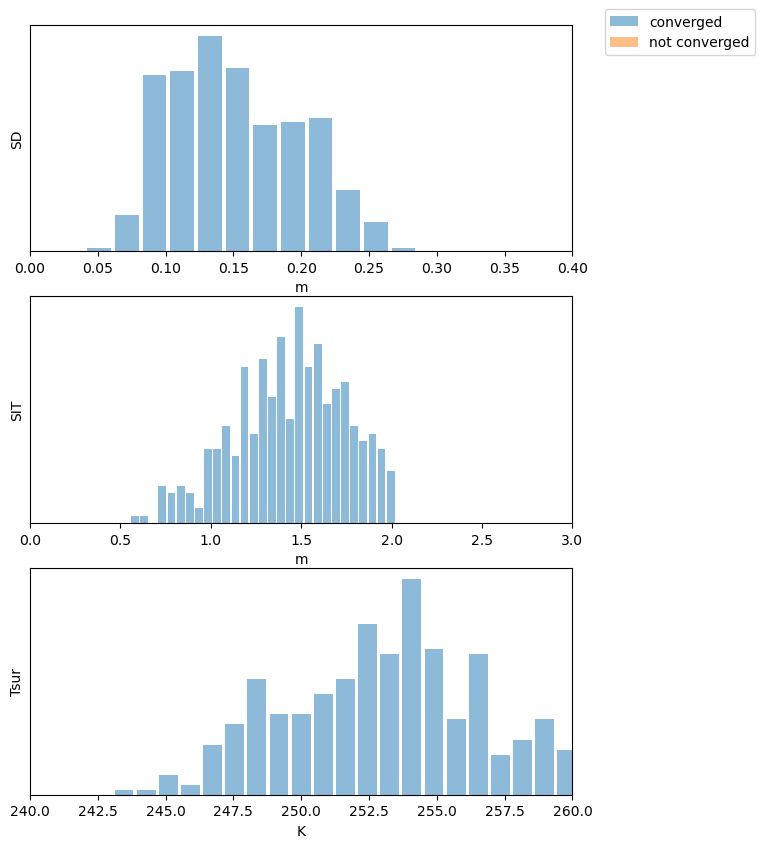

In [16]:
nn  = np.array(nn, dtype=int)
no  = np.array(no, dtype=int)

fig, ax = plt.subplots(3, figsize=(7,10), sharex=False)

vars = ['SD', 'SIT', 'Tsur']
xlabel = ['m', 'm','K']
xlim = [[0,0.4], [0,3], [240, 260]]
binss = [np.linspace(0, 1, 50), np.linspace(0, 5, 100), np.linspace(230, 270, 50)]
# bins = 
for var, i in zip([np.sum(FYI_data.sd, axis=1), FYI_data.sit, FYI_data.skt], range(3)):
    bins = binss[i]
    ax[i].hist(var[nn], bins=bins, rwidth=0.85, alpha=0.5, label = 'converged')
    ax[i].hist(var[no], bins=bins, rwidth=0.85, alpha=0.5, label='not converged')
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(vars[i]))
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_xlim(xlim[i])
plt.legend(bbox_to_anchor=(1.35, 3.5))

['SD', 'SIT']
Root Mean Square Error:
0.037516806491846195
[ 17  19  20  21  22  24  25  26  65  81  82  97  99 100 112 114 121 129
 130 131 132 133 134 135 136 137 148 153 170 171 172 173 184 192 200 211
 212 213 216 225 238 239 241 242 243 245 246 247 248 249 250 253 260 264
 265 266 269 270 271 272 273 275 278 281 285 287 288 290 291 292 293 296
 301 306 307 308 309 310 311 312 313 314 317 318 319 320 321 324 325 326
 327 330 331 332 333 334 335 336 338 340 341 342 343 345 346 347 348 349
 350]
R2-score:  0.38576699575883255
Root Mean Square Error:
0.037516806491846195


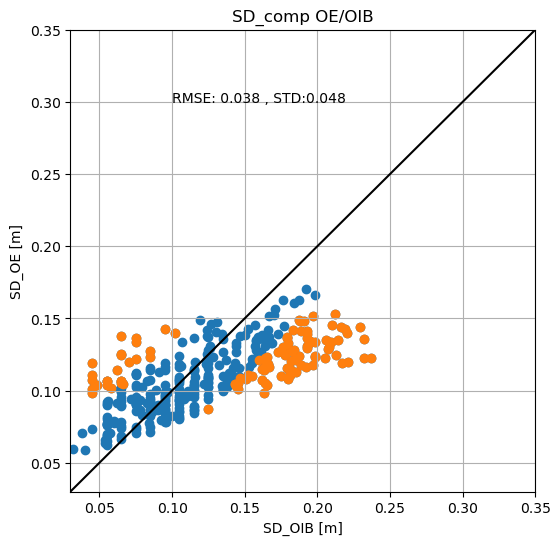

Root Mean Square Error:
0.2777089256891552
R2-score:  0.1631238753742511
Root Mean Square Error:
0.2777089256891552


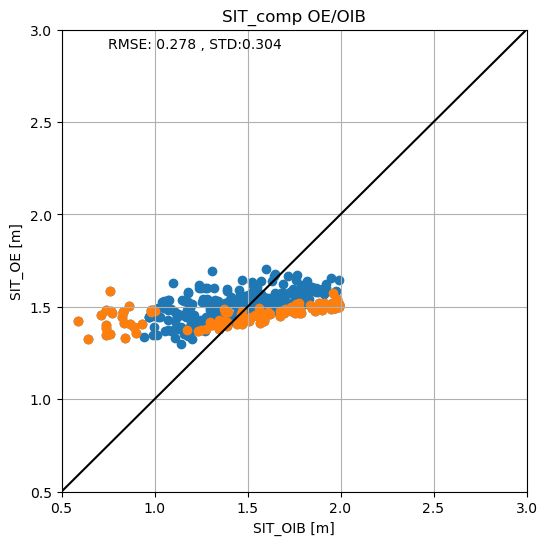

In [17]:
def plot_idv(variables, OIB_data, nn):

   
    for var, data in zip(variables, OIB_data): 
        OE = []
        OIB = []
        #set limits
        for x_optim, n in zip(x_optimals, nn):
            try:
                if var=='SD' or var=='sal' or var=='lex':
                    # convert from log to linear units
                    OE.append(10**x_optim[var])
                else:
                    OE.append(x_optim[var])
                OIB.append(data[n])
            except:
                print('convergence was not reached at: ', n)
        
        if var=='SD' or var=='sal' or var=='lex':
            OIB = np.array(OIB)[:,0]
        
        #print(np.shape(OIB))
        #print(np.shape(OE))
        if var=='SD':
            xlim = [0.03, 0.35]
            x = 0.1
            y = 0.30
            unit = ' [m]'
        elif var=='sal':
            xlim = [0.5, 2.0]
            unit = ' [PSU]'
            OIB = OIB*1e3
            x = 0.8
            y = 1.9
            OE = np.array(OE)*1e3
        elif var=='lex':
            xlim = [0.15, 0.3]
            unit = ' [mm]'
            x = 0.18
            y = 0.28
            OIB = OIB*1e3
            OE = np.array(OE)*1e3
        elif var=='SIT':
            xlim = [0.5, 3.0]
            x = 0.75
            y = 2.90
            unit = ' [m]'
        
        
        diag = np.linspace(0,400,400)

        plt.figure(figsize=(6,6))
        rmse = RMSE(OIB, OE)
        if var=='SD':
            BD = np.where(abs(OIB-OE)>rmse)[0]
            print(BD)
        plt.scatter(OIB, OE)
        plt.scatter(np.array(OIB)[BD.astype(int)], np.array(OE)[BD.astype(int)])
        plt.plot(diag, diag, 'k')
        plt.grid()
        plt.title(var + '_comp OE/OIB')
        plt.xlabel(var + '_OIB' + unit)
        plt.ylabel(var + '_OE' + unit)
        plt.xlim(xlim)
        # square plot
        plt.ylim(xlim)
        
        print('R2-score: ',r2_score(OIB,OE))
        # print(np.std(OIB))
        plt.text(x, y, 'RMSE: ' + str(np.round(RMSE(OIB, OE),3)) + ' , STD:' + str(np.round(np.std(OIB),3)))
        plt.savefig(savepath + var + '_' + str(V_sens) +'_SD2xcov_idv.png' )
        plt.show()
        
    return BD



# take nn of each
OIB_data = []
print(input_variables)
if 'SD' in input_variables:
    OIB_data.append(FYI_data.sd)
if 'lex' in input_variables:
    OIB_data.append(FYI_data.sd_lex)
if 'sal' in input_variables:
    OIB_data.append(FYI_data.sd_sal)
if 'SIT' in input_variables:
    OIB_data.append(FYI_data.sit)
BD = plot_idv(input_variables, OIB_data, nn)

In [18]:
FYI_data.lat[BD]
FYI_data.lon[BD]
FYI_data.date[BD]

array([b'2013-03-22T12:00:00Z', b'2013-03-22T12:00:00Z',
       b'2013-03-22T12:00:00Z', b'2013-03-22T12:00:00Z',
       b'2013-03-22T12:00:00Z', b'2013-03-22T12:00:00Z',
       b'2013-03-22T12:00:00Z', b'2013-03-22T12:00:00Z',
       b'2013-03-23T12:00:00Z', b'2013-03-24T12:00:00Z',
       b'2013-03-24T12:00:00Z', b'2013-03-24T12:00:00Z',
       b'2013-03-24T12:00:00Z', b'2013-03-24T12:00:00Z',
       b'2013-04-22T12:00:00Z', b'2014-03-12T12:00:00Z',
       b'2014-03-12T12:00:00Z', b'2014-03-15T12:00:00Z',
       b'2014-03-15T12:00:00Z', b'2014-03-15T12:00:00Z',
       b'2014-03-15T12:00:00Z', b'2014-03-15T12:00:00Z',
       b'2014-03-15T12:00:00Z', b'2014-03-15T12:00:00Z',
       b'2014-03-17T12:00:00Z', b'2014-03-17T12:00:00Z',
       b'2014-03-18T12:00:00Z', b'2014-03-19T12:00:00Z',
       b'2016-04-20T20:55:33', b'2016-04-20T20:59:08',
       b'2016-04-29T12:34:26', b'2017-03-10T17:23:51',
       b'2017-03-12T19:59:57', b'2017-03-12T20:33:42',
       b'2017-03-12T20:59:09', b'2017

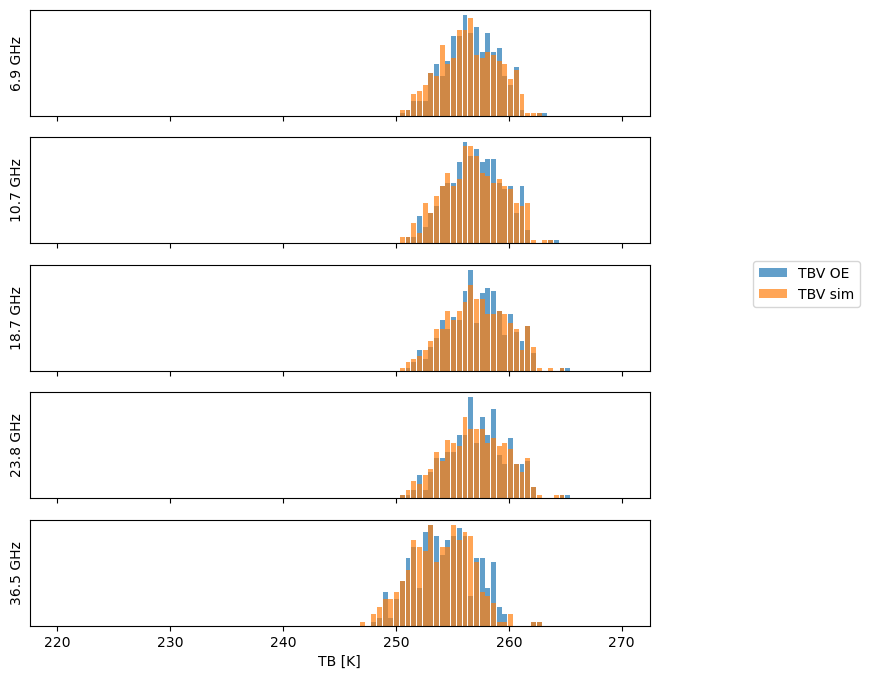

In [19]:
nnn = np.array(nn, dtype=int)
fig, ax = plt.subplots(5, figsize=(8,8), sharex=True)
freqs=[6.9,10.7,18.7,23.8,36.5];
for i in range(5):
    bins = np.linspace(220, 270, 100)
    ax[i].hist([res[i] for res in results], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].hist([TbV[i] for TbV in FYI_data.TbV_sim[nn]], bins=bins, rwidth=0.85, alpha=0.7)
    if polarization=='both':
        ax[i].hist([res[i+5] for res in results], bins=bins, rwidth=0.85, alpha=0.7)
        ax[i].hist([TbH[i] for TbH in FYI_data.TbH_sim[nn]], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(freqs[i]) + ' GHz')
plt.xlabel('TB [K]')
plt.legend(['TBV OE', 'TBV sim', 'TBH OE', 'TBH sim'], bbox_to_anchor=(1.35, 3.5))
plt.savefig(savepath + str(V_sens) + '_Hist_TB.png' )
# plt.legend(['TBV OE', 'TBV generated', 'TBH OE', 'TBH generated'], bbox_to_anchor=(1.35, 3.5))
# plt.title('Simulated and Generated TBs')